In [1]:
import atmPy.radiation.retrievals.langley_calibration as atmlc

In [2]:
import helpers

# AOD

In [3]:
prefix = '/Users/htelg'

## langley calibration

### load calibration

In [4]:
V0 = xr.open_dataset('data/V0_simple_649.nc')

# look up table

In [5]:
fnlut = '/Users/htelg/projects/mfrsr2pwv/data/pwd_od_lut_649.nc'
ds_lut = xr.open_dataset(fnlut)
ds_lut.attrs.update({'path2file': fnlut})

# the product

In [6]:
import atmPy.radiation.retrievals.spectral_irradiance as atmspec
import atmPy.aerosols.physics.column_optical_properties as atmcop

In [7]:
reload(atmspec)

<module 'atmPy.radiation.retrievals.spectral_irradiance' from '/Users/htelg/prog/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py'>

In [30]:
def make_product(fn,
                 fnmet,
                 fnlut,
                 langley_calibration,
                 serial_no,
                 version):
    
    ds = xr.open_dataset(fn)
    dsmet = xr.open_dataset(fnmet)
    gdd = atmspec.CombinedGlobalDiffuseDirect(ds.copy())
    gdd.dataset['channel_wavelength'] = gdd.dataset.channel_wavelength.astype(float) #error in processing upstream, fix it in future versions!
    gdd = gdd.apply_calibration_langley(langley_calibration)
    
    ### Moving to direct
    dni = gdd.direct_normal_irradiation
    dni.verbose = True
    
    # met data
    dni.met_data = dsmet
    
    #lookuptable for precipitagble water
    dni.precipitable_water = fnlut
    
    # ozone
    # dni.ozone_data = 300
    ozone = dsmet.ozone.where(dsmet.ozone != -99.999)
    ozone = ozone.interpolate_na('time', method = 'nearest', fill_value = 'extrapolate')
    dni.ozone_data = ozone
    
    # retrieve it all
    dni.raw_data.attrs['serial_no'] = serial_no #when looking for filters it will need the serial number

    dni.aod #this will trigger the retrieval and populate the raw_data
    
    # create cloud flag
    aod = atmcop.AOD_AOT(dni.raw_data)
    cm = aod.cloudmask.cloudmask_michalsky
    cm = cm.where(~ np.isnan(cm), 2).astype('int8')
    cm.attrs.update({
        "long_name": "cloud detection flag",
        "standard_name": "status_flag",
        "units": "1",
        "flag_values": '0, 1, 2',
        "flag_meanings": "no_cloud_detected cloud_detected algorithm_not_run",
        "description": (
            "0 = no cloud detected; 1 = cloud detected; "
            "2 = algorithm could not be evaluated"
        ),
    })
    dni.raw_data['cloud_flag'] = cm
    
    # format the file
    drop = ['alltime','toa_spectral_irradiance','ozone_absorption_spectrum', 'ozon_absoption_by_channel', 'wavelength', 'direct_horizontal']
    prod = dni.raw_data.drop_vars(drop)
    od1625 = dni.od_co2_ch4_h2o.sel(channel = 1625, drop = True)
    prod['od_1625nm_co2'] = od1625.co2
    prod['od_1625nm_ch4'] = od1625.ch4
    prod['od_1625nm_h2o'] = od1625.h2o_5cm
    
       
    
    prod = prod[["aod",
                 "cloud_flag",
                "precipitable_water",
                "transmission",
                "global_horizontal",
                "diffuse_horizontal",
                "direct_normal",
                "od_rayleigh",
                "od_ozone",
                "od_1625nm_co2",
                "od_1625nm_ch4",
                "od_1625nm_h2o",
                "channel_wavelength",
                "cosine_calibraion_direct",
                "solar_zenith_angle",
                "solar_azimuth_angle",
                "pressure",
                "temperature",
                "ozone_data",]]

    # remove the 940 channel
    # prod = prod.sel(channel=[i for i in ds.channel.values if i != 940])
    
    # add some attributes
    attrs = dict(description = 'Spectral AOD, downwelling fluxes, and precipitable water from NOAA/GRAD MFRSR instruments during 2025 FRC in Davos',
                site_longitude = f'{360 + prod.attrs['site_longitude']:0.6f}',
                site_latitude = f'{prod.attrs['site_latitude']:0.6f}',
                 serial_no = prod.attrs['serial_no'],
                 instrument_type = prod.attrs['instrument_type'],
                 input_files = ', '.join([fn.as_posix(), fnmet.as_posix(), fnlut.attrs['path2file']]),
                 processing_timestamp = f'{pd.Timestamp.now()}',
                 product_version = version
                )          
    
    prod.attrs = attrs
    out = {'product': prod, 'dni_inst': dni}
    return out

In [31]:
# Test
out = make_product(fn = pl.Path(f'{prefix}/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/649.cal/v0.1/frc_649_v0.1_20250929.nc'),
                 fnmet = pl.Path(f'{prefix}/nfs/grad/campaign/frc/2025/MetaData.netcdf/frc-vi_metadata_20250929_preliminary.nc'),
                 fnlut =  ds_lut,
                 langley_calibration = V0,
                 serial_no = 649,
                 version = 0.1)
# dni = out

whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.


In [32]:
ds = out['product']

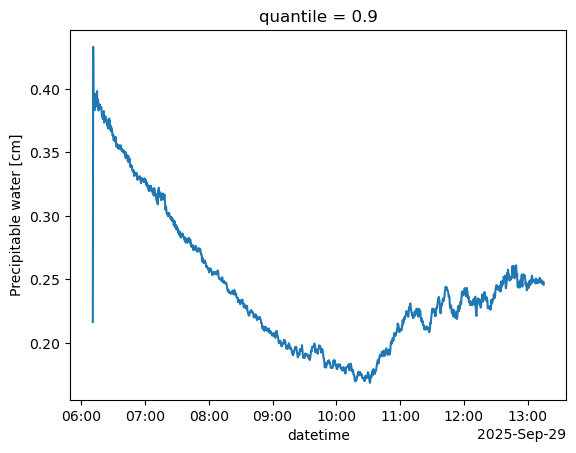

In [33]:
ds.precipitable_water.plot()

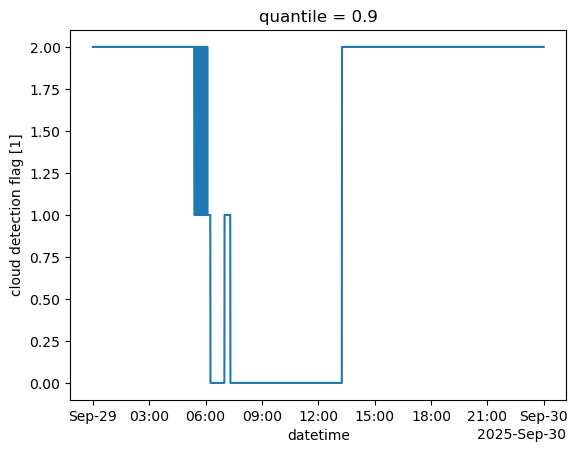

In [34]:
ds.cloud_flag.plot()

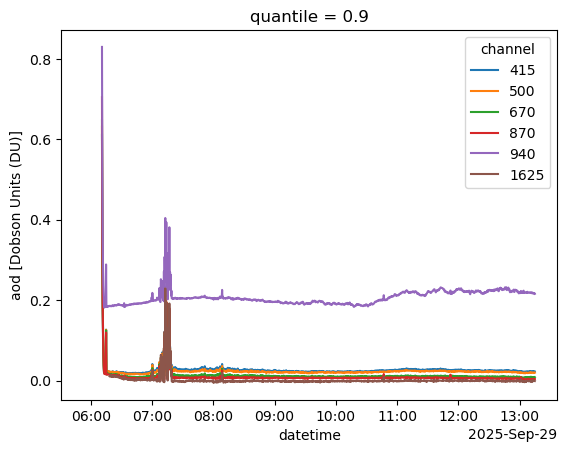

In [35]:
ds.aod.plot.line(x = 'datetime')


# Workplan

In [46]:
version = '0.2'
serial_no = 649
p2fld_out = pl.Path(f'{prefix}/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#9/netcdf/v{version}/')
p2fld_mfrsr = pl.Path(f'{prefix}/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serial_no}.cal/v0.1/')
p2fld_met = pl.Path(f'{prefix}/nfs/grad/campaign/frc/2025/MetaData.netcdf/')
"""changelog
------------
== v0.2== 
- subtruct aod from 940 by extrapolating with angstrom exponent
"""

'changelog\n------------\n== v0.2== \n- subtruct aod from 940 by extrapolating with angstrom exponent\n'

In [47]:
dfmfrsr = pd.DataFrame(p2fld_mfrsr.glob('*.nc'), columns=['p2f_mfrsr_in'])
dfmfrsr.index = dfmfrsr.apply(lambda row: pd.to_datetime(row.p2f_mfrsr_in.name.split('_')[-1].replace('.nc','')), axis =1)

dfmet = pd.DataFrame(p2fld_met.glob('*.nc'), columns=['p2f_met'])
dfmet.index = dfmet.apply(lambda row: pd.to_datetime(row.p2f_met.name.split('_')[-2]), axis = 1)

mp = pd.concat([dfmfrsr,dfmet], axis = 1)
mp['p2f_out'] = mp.apply(lambda row: p2fld_out.joinpath(f'aod_frc_{serial_no}_v{version}_{row.name.strftime('%Y%m%d')}.nc'), axis = 1)

In [48]:
wp = mp.dropna()
wp = wp[~wp.apply(lambda row: row.p2f_out.exists(), axis = 1)]

In [49]:
wp

,p2f_mfrsr_in,p2f_met,p2f_out
2025-09-21,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-25,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-26,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-27,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-28,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-29,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-01,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-02,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-03,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-04,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...


# work it

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
for idx, row in wp.iterrows():
    if row.p2f_out.exists():
        continue

    try:
        out = make_product(fn = row.p2f_mfrsr_in,
                 fnmet = row.p2f_met,
                 fnlut =  ds_lut,
                 langley_calibration = V0,
                 serial_no = 649,
                 version = 0.1)
        
        prod = out['product']
        row.p2f_out.parent.mkdir(parents=True, exist_ok=True)
        prod.to_netcdf(row.p2f_out)
    except:
        raise
        print('something went wrong')
        continue

whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.
whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.
whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.
whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.
whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.
whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.
whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 940nm channel using lookup table.
whatup
Renaming time coordinate to datetime for ozone data.
Retrieving precipitable water from 94

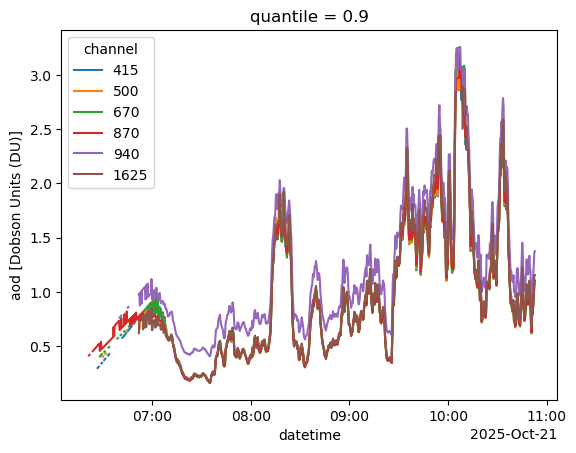

In [52]:
prod.aod.plot.line(x = 'datetime')

In [53]:
p2fl = list(p2fld_out.glob('*'))
p2fl.sort()

In [54]:
ds = xr.open_mfdataset(p2fl)

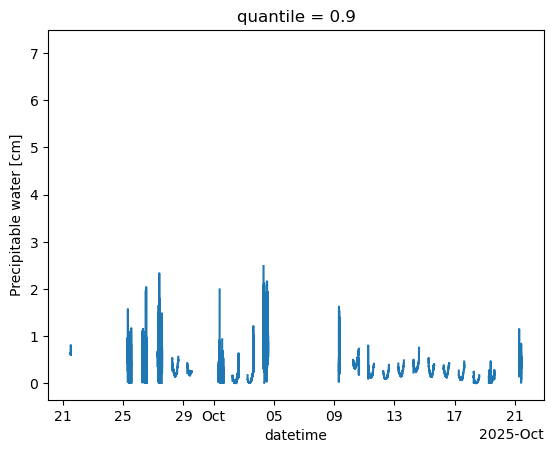

In [55]:
ds.precipitable_water.plot()